When someone mentions "Question Answering" as an application of BERT, what they are really referring to is applying BERT to the Stanford Question Answering Dataset (SQuAD).

In [2]:
#install hugging face transformer
# the transformer library has big collection of pretrained models which can be references via name

!pip install transformers

     |████████████████████████████████| 778kB 2.8MB/s 
     |████████████████████████████████| 3.0MB 16.5MB/s 
     |████████████████████████████████| 890kB 28.9MB/s 
     |████████████████████████████████| 1.1MB 41.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=316fe4454c0dcefa5dde5bcd900a02b2c931c07f59be38bc4373c6da85bf614f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
# to implement using pytorch

import torch

In [4]:
# import specific class for Question and Answering

from transformers import BertForQuestionAnswering
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Try asking a question

In [5]:
question = 'how many parametres does BERT-large have ?'
answer_text = "BERT-large is really big... it has 24-layers and an embedding size of 1,024, for a total of 340M parameters! Altogether it is 1.34GB, so expect it to take a couple minutes to download to your Colab instance."

In [6]:
# use a BERT tokenizer to tokenizer and encode the Q&A

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

In [7]:
# apply the tokenizer to the input text and create them as question-answer pair

input_ids = tokenizer.encode(question, answer_text)
print('the input has {} number of tokens'.format(len(input_ids)))

the input has 72 number of tokens


Print the tokens and their ids so that we can see what the tokenizer is actually doing

In [8]:
tokenizer.all_special_tokens

['[UNK]', '[MASK]', '[PAD]', '[CLS]', '[SEP]']

In [9]:
tokenizer.cls_token_id

101

In [10]:
# BERT only needs the token IDs, but for the purpose of inspecting the 
# tokenizer's behavior, let's also get the token strings and display them.
tokens = tokenizer.convert_ids_to_tokens(input_ids)

for token, id in zip(tokens, input_ids):

    # if this is [CLS] or [SEP] token, make it stand out
    if id == tokenizer.cls_token_id or id == tokenizer.sep_token_id:
        print("\n")
    
    # for the rest print the token and the corresponding token id
    print('{:<12} --> {:>6}'.format(token, id))



[CLS]        -->    101
how          -->   2129
many         -->   2116
para         -->  11498
##met        -->  11368
##res        -->   6072
does         -->   2515
bert         -->  14324
-            -->   1011
large        -->   2312
have         -->   2031
?            -->   1029


[SEP]        -->    102
bert         -->  14324
-            -->   1011
large        -->   2312
is           -->   2003
really       -->   2428
big          -->   2502
.            -->   1012
.            -->   1012
.            -->   1012
it           -->   2009
has          -->   2038
24           -->   2484
-            -->   1011
layers       -->   9014
and          -->   1998
an           -->   2019
em           -->   7861
##bed        -->   8270
##ding       -->   4667
size         -->   2946
of           -->   1997
1            -->   1015
,            -->   1010
02           -->   6185
##4          -->   2549
,            -->   1010
for          -->   2005
a            -->   1037
total       

We've concatenated the question and answer_text together, but BERT still needs a way to distinguish them. BERT has two special **"Segment" embeddings**, one for segment "A" and one for segment "B". Before the word embeddings go into the BERT layers, the segment A embedding needs to be added to the question tokens, and the segment B embedding needs to be added to each of the answer_text tokens.

These additions are handled for us by the transformer library, and all we need to do is specify a '0' or '1' for each token.

In [11]:
# Now lets create the Segment embeddings

# first search the input_ids for the first instance of [SEP] token - this will give us the question
# this gives the position of the first [SEP] token
sep_index = input_ids.index(tokenizer.sep_token_id)

# the number of segment A tokens should include the [SEP] token as well
num_seg_a = sep_index + 1

# So the remanining, which is for the answer text should belong to Segment B
num_seg_b = len(input_ids) - num_seg_a

# Fill the segments with 1's and 0's
segment_ids = [0]*num_seg_a + [1]*num_seg_b

# there should be now a segment id for every input token
# check the lengths are same

assert len(segment_ids)== len(input_ids)

Side Note: Where's the padding?

The original example code does not perform any __padding__. I suspect that this is because we are only feeding in a single example. If we instead fed in a __batch of examples__, then we would need to __pad or truncate__ all of the samples in the batch to a single length, and supply an __attention mask__ to tell BERT to ignore the __padding tokens__.

In [12]:
# Run the example through the model

start_scores, end_scores = model(torch.tensor([input_ids]), # the tokens representing out input text
                                token_type_ids = torch.tensor([segment_ids])) # the segment ids to differentiate between question and text

In [13]:
# find the token with the highest start and end scores

answer_start = torch.argmax(start_scores)
answer_end = torch.argmax(end_scores)

# combine the tokens in the answer
answer = ' '.join(tokens[answer_start: answer_end+2])

print('Answer: ', answer)

Answer:  340 ##m


In [14]:
tokens[answer_end+1]

'##m'

With a little more effort, we can reconstruct any words that got broken down into subwords.

In [15]:
# start from the first token

answer = tokens[answer_start]

# now select the remaning tokens and join them with whitespace
for i in range(answer_start + 1, answer_end + 2):
  # if it is a subowrd token then combine with the previous token
  if tokens[i][0:2] == "##":
    answer += tokens[i][2:]
  
  # else if not a subword, then add a whitespace
  else:
    answer += ' ' + tokens[i]
  
  print(answer)

340m


Visualizing the scores

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='darkgrid')

# increase the font size in the plot
plt.rcParams["figure.figsize"] = (16,8)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [17]:
# Retrieve all the start_scores, end_scores and use the tokens on the x-axis

# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays
s_scores = start_scores.detach().numpy().flatten()
e_scores = end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one

token_labels= []

for (i, token) in enumerate(tokens):
  token_labels.append('{:} - {:}'.format(token, i))

Create a bar plot showing the score for every input word being the "start" word.

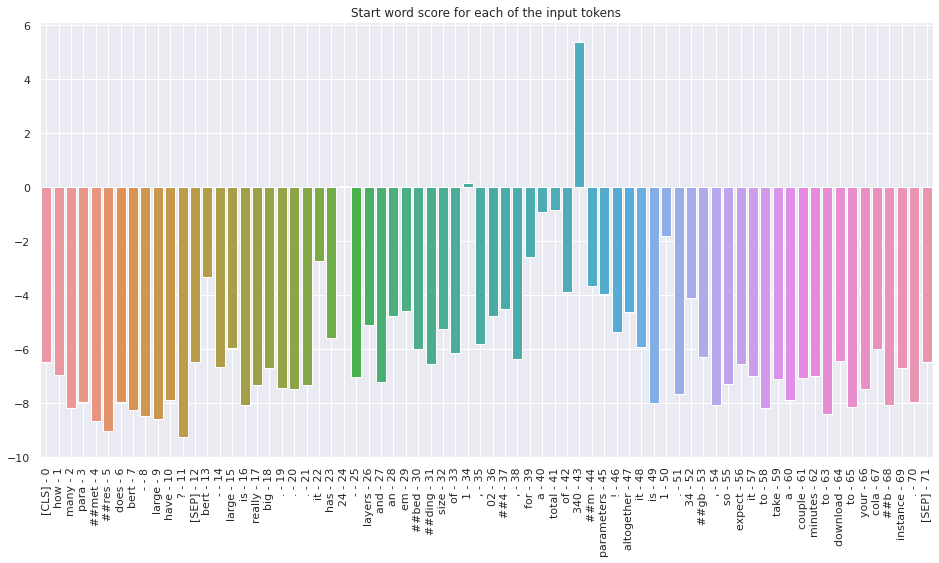

In [18]:
# create a barplot for the start scores

ax = sns.barplot(x = token_labels, y = s_scores)

# turn the xlabel vertical
ax.set_xticklabels(rotation=90, labels = ax.get_xticklabels(), ha='center')

# turn on vertical grid
ax.grid(True)

plt.title('Start word score for each of the input tokens')
plt.show()

Create a bar plot showing the score for every input word being the "end" word.

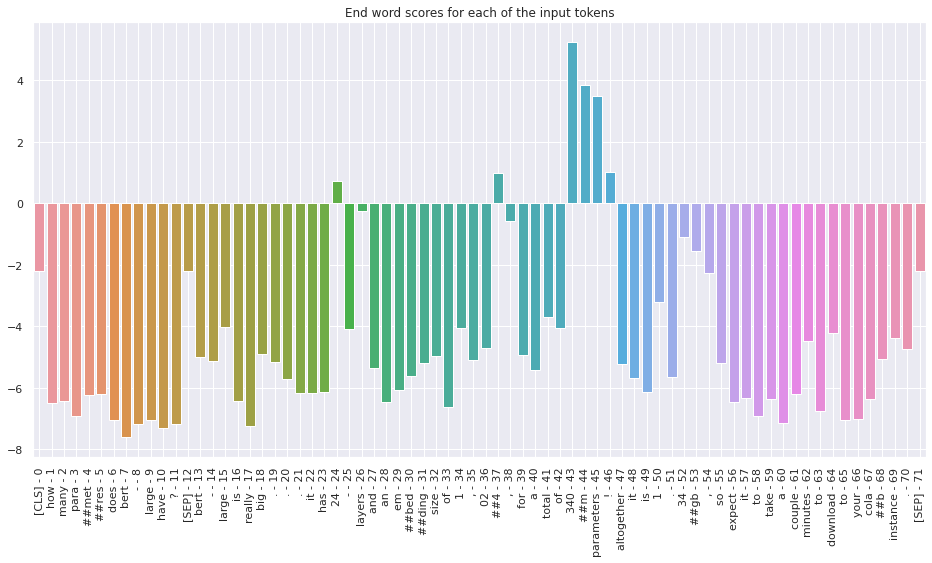

In [19]:
# for the end word, scores

ax = sns.barplot(x = token_labels, y = e_scores)

# set orientation to vertical

ax.set_xticklabels(labels = ax.get_xticklabels(), rotation=90, ha='center')
ax.grid(True)
plt.title('End word scores for each of the input tokens')
plt.show()

In [20]:
scores = []

for (i, token_label) in enumerate(token_labels):
  # we will create 2 rows for each token for start and end scores

  scores.append({
                  'token_label': token_label,
                  'score': s_scores[i],
                  'marker': 'start'
              })
  
  scores.append({
                  'token_label': token_label,
                  'score': e_scores[i],
                  'marker': 'end'
                })
  
  import pandas as pd

  # store the information into a df
  df = pd.DataFrame(scores)

In [21]:
df.head(10)

,token_label,score,marker
0,[CLS] - 0,-6.478109,start
1,[CLS] - 0,-2.213068,end
2,how - 1,-6.962019,start
3,how - 1,-6.493917,end
4,many - 2,-8.177321,start
5,many - 2,-6.448602,end
6,para - 3,-7.970856,start
7,para - 3,-6.929966,end
8,##met - 4,-8.665893,start
9,##met - 4,-6.250424,end


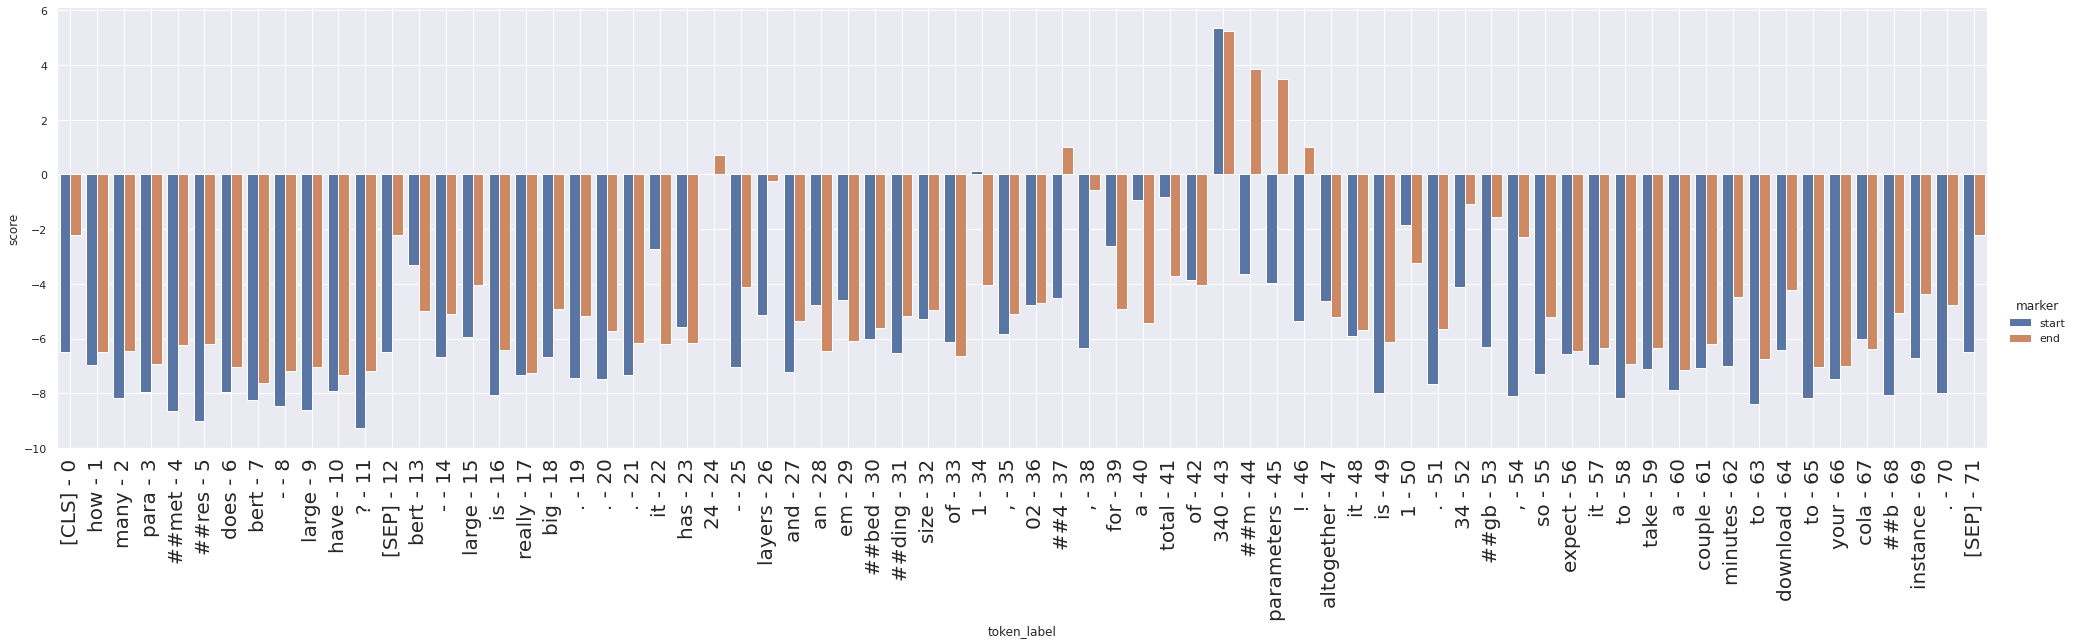

In [22]:
# plot the start and end score together in a single plot

g = sns.catplot(x = 'token_label', y = 'score', hue='marker', data=df, kind='bar', height=7, aspect=4)

g.ax.set_xticklabels(g.ax.get_xticklabels(), rotation=90, ha='center', fontsize=20)
g.ax.grid(True)
#plt.xticks(fontsize=20)
plt.show()

## Turn the QA into a function

In [35]:
def answer_question(question, answer_text):

  #===========Tokenize=============#
  # apply the tokenizer to the input text, treating them as question, answer pair
  input_ids =  tokenizer.encode(question, answer_text)

  # Check how long is the input_ids or how many tokens exist
  print('Query has {} tokens\n'.format(len(input_ids)))

  #==========Set Segmend ids=========#
  # search the input_ids for the first instance of [SEP] token
  # find the index
  sep_index = input_ids.index(tokenizer.sep_token_id)

  # the number of tokens belonging to Segment A also include the [SEP] token
  num_seg_a = sep_index + 1

  # the remaining belongs to Segment B
  num_seg_b = len(input_ids) - num_seg_a

  # Construct the segments with 1s and 0s
  segment_ids = [0]*num_seg_a + [1]*num_seg_b

  # there should be a segment_ids for every token
  assert len(segment_ids) == len(input_ids)

  # ========Evaluate the model===========#
  # run the example question through the model

  start_scores, end_scores = model(torch.tensor([input_ids]), token_type_ids = torch.tensor([segment_ids]))

  #========Reconstruct Answer===========#
  answer_start = torch.argmax(start_scores)
  answer_end = torch.argmax(end_scores)

  # get the string version of the input tokens
  tokens = tokenizer.convert_ids_to_tokens(input_ids)

  # answer starts with the first token
  answer = tokens[answer_start]

  # select the remaining answer tokens and join them with white space
  for i in range(answer_start+1, answer_end+1):
    # if it is sub-word, join them with the previous token
    if tokens[i][0:2] == '##':
      answer += tokens[i][2:]
    else:
      answer += " "+ tokens[i]

  print('Answer:', answer)

As our reference text, taking the Abstract of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf).

In [29]:
bert_abstract = "We introduce a new language representation model called BERT, which stands for Bidirectional Encoder Representations from Transformers. Unlike recent language representation models (Peters et al., 2018a; Radford et al., 2018), BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. As a result, the pre-trained BERT model can be finetuned with just one additional output layer to create state-of-the-art models for a wide range of tasks, such as question answering and language inference, without substantial taskspecific architecture modifications. BERT is conceptually simple and empirically powerful. It obtains new state-of-the-art results on eleven natural language processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1 question answering Test F1 to 93.2 (1.5 point absolute improvement) and SQuAD v2.0 Test F1 to 83.1 (5.1 point absolute improvement)."


In [33]:
# format the appearance of the text
import textwrap

# wrap text to 80 characters
wrapper = textwrap.TextWrapper(width=80)

print(wrapper.fill(bert_abstract))

We introduce a new language representation model called BERT, which stands for
Bidirectional Encoder Representations from Transformers. Unlike recent language
representation models (Peters et al., 2018a; Radford et al., 2018), BERT is
designed to pretrain deep bidirectional representations from unlabeled text by
jointly conditioning on both left and right context in all layers. As a result,
the pre-trained BERT model can be finetuned with just one additional output
layer to create state-of-the-art models for a wide range of tasks, such as
question answering and language inference, without substantial taskspecific
architecture modifications. BERT is conceptually simple and empirically
powerful. It obtains new state-of-the-art results on eleven natural language
processing tasks, including pushing the GLUE score to 80.5% (7.7% point absolute
improvement), MultiNLI accuracy to 86.7% (4.6% absolute improvement), SQuAD v1.1
question answering Test F1 to 93.2 (1.5 point absolute improvement) 

In [36]:
# Q.1 Ask the model whose does BERT stand for ?

question = "What does BERT stand for?"

answer_question(question, bert_abstract)

Query has 253 tokens

Answer: bidirectional encoder representations from transformers


In [37]:
# Q.2
question = "What is the accuracy of the BERT model"

answer_question(question, bert_abstract)

Query has 255 tokens

Answer: 86 . 7 %


In [38]:
# Q.3
question = "how can bert be fine-tuned?"

answer_question(question, bert_abstract)

Query has 255 tokens

Answer: with just one additional output layer


In [41]:
# Q.4
question = "Applications of the BERT model?"

answer_question(question, bert_abstract)

Query has 253 tokens

Answer: question answering and language inference


In [43]:
# Q.5
question = "What is the F1 score for SQuaDv1.1?"

answer_question(question, bert_abstract)

Query has 265 tokens

Answer: 93 . 2


In [44]:
# Q.6
question = "What is the F1 score for SQuaDv2.0?"

answer_question(question, bert_abstract)

Query has 259 tokens

Answer: 83 . 1
